# Seoul Air Quality Level Prediction

## 1. Seoul Air Quality Dataset

This dataset is collected from @seoul_air, including Seoul air quality data from 2008 to 2018. Air quality is impacted by many factors such as traffic volume, neighboring area AQ situations, weather, seasonal information, and other economic activities. Many works have addressed the relationship between AQ level and other factors via numerous modeling approaches. For instance, during the Chuseok holidays, the AQI tends to get better, while it is serious during weekdays, especially with foggy weather conditions or in the yellow dust season. You can refer to [3-5] for more information on how researchers used this dataset in their works.

| Column | Description |
|---------|---------|
| Datetime | Timestamp |
| District | District code 0-25 (Code 0 represents the average value of all 25 districts in Seoul). Other districts are identified from 1 to 25.  The order of district codes is 0 - 평균, 1 - 종로구, 2 - 중구, 3 - 용산구, 4 - 성동구, 5 - 광진구, 6 - 동대문구, 7 - 중랑구, 8 - 성북구, 9 - 강북구, 10 - 도봉구, 11 - 노원구, 12 - 은평구, 13 - 서대문구, 14 - 마포구, 15 - 양천구, 16 - 강서구, 17 - 구로구, 18 - 금천구, 19 - 영등포구, 20 - 동작구, 21 - 관악구, 22 - 서초구, 23 - 강남구, 24 - 송파구, 25 - 강동구 |
| PM10_CONC | PM10 concentration (µg/m3) |
| PM2_5_CONC | PM2.5 concentration (µg/m3) |
|O3         | Ozone concentration (µg/m3) |
| NO2 | NO2 concentration (µg/m3) |
| CO | CO concentration (µg/m3) |
| SO2 | SO2 concentration (µg/m3) |
| PM10_AQI | PM10 AQI Index according to US Standard AQI Index |
| PM2_5_AQI | PM2.5 AQI Index according to US Standard AQI Index |

## 2. Additional Data Sources
<figure>
<img src="./_images/ml_system.png" alt="ml_system" width="80%" height="80%">
<figcaption>Image Source From https://proceedings.neurips.cc/paper/2015/file/86df7dcfd896fcaf2674f757a2463eba-Paper.pdf</figcaption>
</figure>

As the figure shows, we spend most of the time on data collection, cleansing, and pre-processing. Only a small amount of time is for machine learning model development. To increase the accuracy of models, we must try to find additional data to verify our hypotheses.

### 2.1 Weather Data

<figure>
<img width="500px" src="./_images/seoul_weather.png" alt="ml_system" width="80%" height="80%">
<figcaption>Seoul Weather from worldweatheronline.com</figcaption>
</figure>

Many researches have pointed out that air quality level relates to weather conditions. For instance, AQ levels get better after a heavy rain, or it usually gets worse during the winter season. For more information, please check out reference papers.

### 2.2 Holiday Information

<figure>
<img width="500px" src="./_images/holiday.png" alt="ml_system" width="80%" height="80%">
<figcaption>Seoul Holidays from timeanddata.com</figcaption>
</figure>

Similar to weather data, we can collect holiday information from websites like timeanddata.com.

## 3. Data Pre-processing

In [1]:
import pandas as pd
import numpy as np

### 3.1 Data loading

As the original Seoul AQ dataset contains 25 information of 25 districts, it's too large for this example. Therefore, we only work with the overall AQ dataset only. In short, we extract city-level air quality data from 2014 -> 2018 from the original dataset.

In [2]:
path = "/home/alexbui/workspace/HandbookForDatascience/notebooks/"

In [3]:
seoul_air = pd.read_csv(path + 'data/seoul_air_avg.csv')
seoul_air.drop(["PM10_AQI", "PM2_5_AQI"], axis=1, inplace=True)
seoul_air.columns = [c.lower() for c in seoul_air.columns]

In [4]:
seoul_air

,datetime,pm10_conc,pm2_5_conc,o3,no2,co,so2
0,2015-01-01 00:00:00,47.0,11.0,0.020,0.012,0.4,0.005
1,2015-01-01 01:00:00,46.0,10.0,0.021,0.010,0.4,0.005
2,2015-01-01 02:00:00,59.0,10.0,0.020,0.010,0.4,0.006
3,2015-01-01 03:00:00,78.0,12.0,0.020,0.009,0.4,0.005
4,2015-01-01 04:00:00,94.0,13.0,0.020,0.007,0.3,0.005
...,...,...,...,...,...,...,...
30338,2018-06-18 07:00:00,46.0,33.0,0.010,0.033,0.5,0.003
30339,2018-06-18 08:00:00,49.0,33.0,0.013,0.037,0.6,0.003
30340,2018-06-18 09:00:00,54.0,37.0,0.022,0.038,0.6,0.004
30341,2018-06-18 10:00:00,62.0,42.0,0.036,0.038,0.6,0.004


***Load weather data***

In [5]:
weather = pd.read_csv(path + "data/weather_forecasts.csv")
weather = weather[weather['datetime'] <= "2018-06-18 11:00:00"]
weather

,datetime,weather,temperature(C),feel_like(C),wind_speed(km/h),wind_direction,wind_gust(km/h),cloud(%),humidity(%),rain(mm),pressure
0,2015-01-01 00:00:00,Patchy snow possible,-7,-16,35,NW,50,12,44,0.0,1021
1,2015-01-01 01:00:00,Patchy snow possible,-7,-16,35,NW,50,12,44,0.0,1021
2,2015-01-01 02:00:00,Patchy snow possible,-7,-16,35,NW,50,12,44,0.0,1021
3,2015-01-01 03:00:00,Clear,-8,-18,36,NW,52,8,42,0.0,1022
4,2015-01-01 04:00:00,Clear,-8,-18,36,NW,52,8,42,0.0,1022
...,...,...,...,...,...,...,...,...,...,...,...
30343,2018-06-18 07:00:00,Partly cloudy,22,23,1,SE,2,49,60,0.0,1008
30344,2018-06-18 08:00:00,Partly cloudy,22,23,1,SE,2,49,60,0.0,1008
30345,2018-06-18 09:00:00,Partly cloudy,26,27,3,SSW,4,44,44,0.0,1009
30346,2018-06-18 10:00:00,Partly cloudy,26,27,3,SSW,4,44,44,0.0,1009


### 3.2 Check missing values

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
for c in seoul_air.columns:
    print(c, seoul_air[c].isnull().sum())

datetime 0
pm10_conc 0
pm2_5_conc 0
o3 0
no2 0
co 0
so2 0


In [8]:
for c in weather.columns:
    print(c, weather[c].isnull().sum())

datetime 0
weather 0
temperature(C) 0
feel_like(C) 0
wind_speed(km/h) 0
wind_direction 0
wind_gust(km/h) 0
cloud(%) 0
humidity(%) 0
rain(mm) 0
pressure 0


### 3.3 Check outlier values

In [9]:
def check_outliners(seoul_air, c):
    col = seoul_air.loc[:,c]
    abs_skew = col.skew()
    mean_v = col.mean()
    median_v = col.median()
    q3 = np.nanpercentile(col, 75)
    q1 = np.nanpercentile(col, 25)
    iqr = (q3 - q1) * 1.5
    ceiling = iqr + q3
    # floor = q1 - iqr 
    # col[(col > ceiling) | (col < floor)]
    print("num of outlier", c, col[col > ceiling].count())
    if abs_skew > 1:
        col[col > ceiling] = median_v
    else:
        col[col > ceiling] = mean_v    

In [10]:
for c in ["temperature(C)",	"feel_like(C)",	"wind_speed(km/h)",	"wind_gust(km/h)", "cloud(%)", "humidity(%)", "rain(mm)", "pressure"]:
    check_outliners(weather, c)

num of outlier temperature(C) 0
num of outlier feel_like(C) 0
num of outlier wind_speed(km/h) 1442
num of outlier wind_gust(km/h) 1707
num of outlier cloud(%) 0
num of outlier humidity(%) 0
num of outlier rain(mm) 2724
num of outlier pressure 0


### 3.4 Merge Air Data & Weather Data

We have to check which datetime data is missing and interpolate it. The simplest way is to filling it with near by neighbors or average values of near by neighbors.

In [11]:
air_weather = pd.merge(weather, seoul_air, on='datetime', how='outer')
air_weather[air_weather['pm10_conc'].isnull()]

,datetime,weather,temperature(C),feel_like(C),wind_speed(km/h),wind_direction,wind_gust(km/h),cloud(%),humidity(%),rain(mm),pressure,pm10_conc,pm2_5_conc,o3,no2,co,so2
5640,2015-08-24 00:00:00,Clear,23,26,6,NNE,11,7,79,0.0,1009,NaN,NaN,NaN,NaN,NaN,NaN
5892,2015-09-03 12:00:00,Partly cloudy,25,27,12,WNW,13,42,63,0.0,1011,NaN,NaN,NaN,NaN,NaN,NaN
15660,2016-10-14 12:00:00,Sunny,20,25,2,E,2,2,51,0.0,1025,NaN,NaN,NaN,NaN,NaN,NaN
22890,2017-08-11 18:00:00,Partly cloudy,30,33,10,ENE,12,34,50,0.0,1008,NaN,NaN,NaN,NaN,NaN,NaN
23570,2017-09-09 02:00:00,Clear,24,30,6,WNW,7,0,68,0.0,1013,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
air_weather2 = air_weather.interpolate(method='linear')
air_weather2[air_weather['pm10_conc'].isnull()]

,datetime,weather,temperature(C),feel_like(C),wind_speed(km/h),wind_direction,wind_gust(km/h),cloud(%),humidity(%),rain(mm),pressure,pm10_conc,pm2_5_conc,o3,no2,co,so2
5640,2015-08-24 00:00:00,Clear,23,26,6,NNE,11,7,79,0.0,1009,40.0,25.0,0.0205,0.0280,0.50,0.004
5892,2015-09-03 12:00:00,Partly cloudy,25,27,12,WNW,13,42,63,0.0,1011,20.0,11.5,0.0475,0.0195,0.35,0.004
15660,2016-10-14 12:00:00,Sunny,20,25,2,E,2,2,51,0.0,1025,64.0,29.5,0.0200,0.0415,0.60,0.005
22890,2017-08-11 18:00:00,Partly cloudy,30,33,10,ENE,12,34,50,0.0,1008,16.5,8.5,0.0385,0.0275,0.35,0.004
23570,2017-09-09 02:00:00,Clear,24,30,6,WNW,7,0,68,0.0,1013,63.5,45.0,0.0200,0.0300,0.70,0.005


### 3.5 Plotting

***Plot correlation to first understand feature interactions***

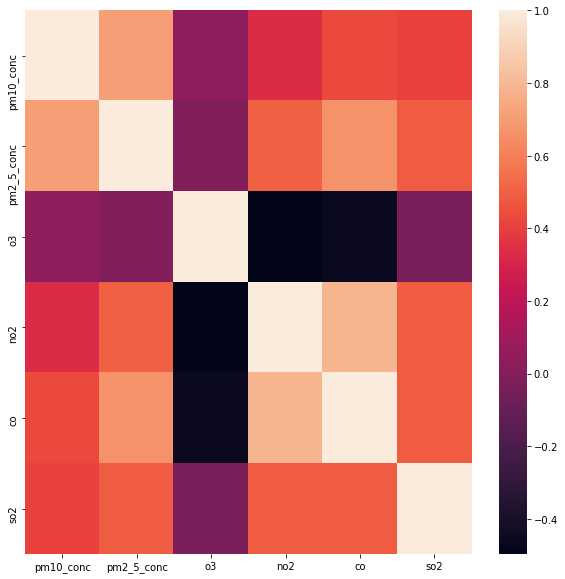

In [13]:
corr = seoul_air.iloc[:,1:7].corr()
fix, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr)
plt.show()

***Align 1h to check correlation with previous hour***

In [14]:
def concat_dataframe(df, timeshift=1):
    df1 = df.iloc[:-timeshift,:]
    df1.columns = [c + "_m%i" % timeshift for c in df1.columns]
    df2 = df.iloc[timeshift:,:].reset_index().drop(["index"],axis=1)
    return pd.concat([df1, df2], axis=1)

In [15]:
def plot_corr(df):
    align_corr = df.corr()
    plt.subplots(figsize=(10,10))
    sns.heatmap(align_corr)
    plt.show()
    return align_corr

In [16]:
align1 = concat_dataframe(seoul_air.iloc[:,1:7], 1)

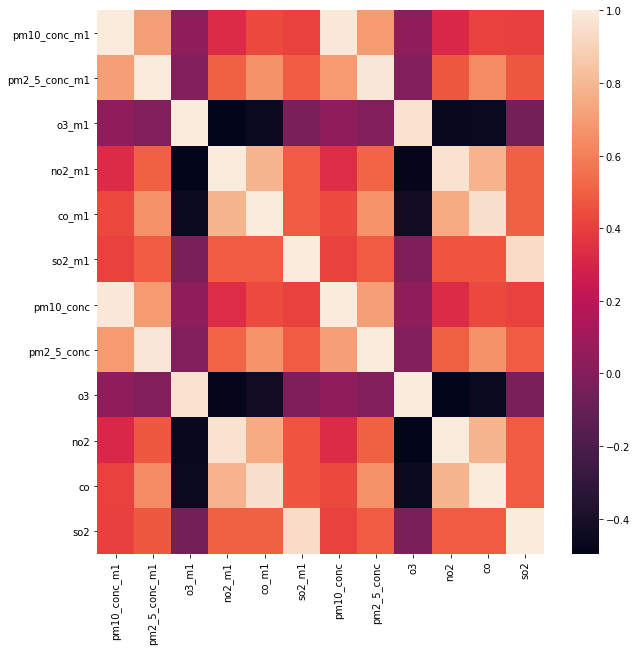

,pm10_conc_m1,pm2_5_conc_m1,o3_m1,no2_m1,co_m1,so2_m1,pm10_conc,pm2_5_conc,o3,no2,co,so2
pm10_conc_m1,1.000000,0.707148,0.043152,0.331551,0.429339,0.415212,0.985114,0.694746,0.043333,0.317219,0.414277,0.405002
pm2_5_conc_m1,0.707148,1.000000,-0.004480,0.499450,0.663576,0.489852,0.695626,0.980768,-0.005004,0.477242,0.642353,0.477063
o3_m1,0.043152,-0.004480,1.000000,-0.496486,-0.452676,-0.033955,0.041748,-0.004744,0.963256,-0.463271,-0.449855,-0.054421
no2_m1,0.331551,0.499450,-0.496486,1.000000,0.783946,0.486873,0.339336,0.512129,-0.481011,0.964764,0.781801,0.501260
co_m1,0.429339,0.663576,-0.452676,0.783946,1.000000,0.486878,0.434231,0.669173,-0.431598,0.749916,0.958776,0.500608
so2_m1,0.415212,0.489852,-0.033955,0.486873,0.486878,1.000000,0.415368,0.489545,-0.017003,0.462926,0.463192,0.936534
pm10_conc,0.985114,0.695626,0.041748,0.339336,0.434231,0.415368,1.000000,0.707158,0.043172,0.331564,0.429340,0.415211
pm2_5_conc,0.694746,0.980768,-0.004744,0.512129,0.669173,0.489545,0.707158,1.000000,-0.004432,0.499431,0.663551,0.489850
o3,0.043333,-0.005004,0.963256,-0.481011,-0.431598,-0.017003,0.043172,-0.004432,1.000000,-0.496480,-0.452674,-0.033952
no2,0.317219,0.477242,-0.463271,0.964764,0.749916,0.462926,0.331564,0.499431,-0.496480,1.000000,0.783945,0.486888


In [17]:
plot_corr(align1)

***Align 4h to check correlation with 4 hours ago***

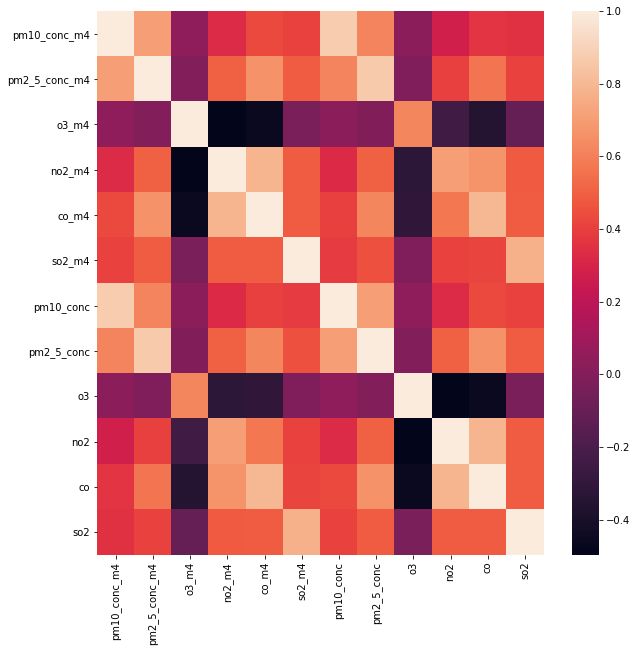

,pm10_conc_m4,pm2_5_conc_m4,o3_m4,no2_m4,co_m4,so2_m4,pm10_conc,pm2_5_conc,o3,no2,co,so2
pm10_conc_m4,1.000000,0.707151,0.043145,0.331543,0.429334,0.415256,0.876869,0.618933,0.032503,0.276897,0.365164,0.354534
pm2_5_conc_m4,0.707151,1.000000,-0.004491,0.499435,0.663572,0.489961,0.618754,0.870130,-0.011483,0.408018,0.564548,0.413484
o3_m4,0.043145,-0.004491,1.000000,-0.496499,-0.452685,-0.033974,0.033781,-0.007799,0.621736,-0.240025,-0.354697,-0.100152
no2_m4,0.331543,0.499435,-0.496499,1.000000,0.783943,0.486946,0.325986,0.502044,-0.318022,0.705311,0.670791,0.479951
co_m4,0.429334,0.663572,-0.452685,0.783943,1.000000,0.486943,0.405671,0.620448,-0.308100,0.574466,0.797095,0.490781
so2_m4,0.415256,0.489961,-0.033974,0.486946,0.486943,1.000000,0.386347,0.454028,-0.011558,0.413558,0.415538,0.772649
pm10_conc,0.876869,0.618754,0.033781,0.325986,0.405671,0.386347,1.000000,0.707240,0.043183,0.331673,0.429383,0.415211
pm2_5_conc,0.618933,0.870130,-0.007799,0.502044,0.620448,0.454028,0.707240,1.000000,-0.004452,0.499371,0.663536,0.489903
o3,0.032503,-0.011483,0.621736,-0.318022,-0.308100,-0.011558,0.043183,-0.004452,1.000000,-0.496566,-0.452697,-0.033946
no2,0.276897,0.408018,-0.240025,0.705311,0.574466,0.413558,0.331673,0.499371,-0.496566,1.000000,0.783954,0.486986


In [18]:
align4 = concat_dataframe(seoul_air.iloc[:,1:7], 4)
plot_corr(align4)

***Plot weather & air quality together***

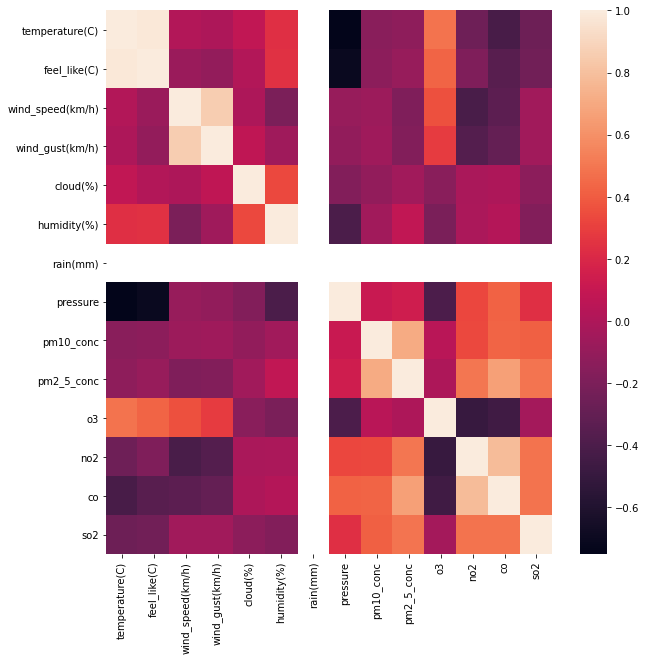

,temperature(C),feel_like(C),wind_speed(km/h),wind_gust(km/h),cloud(%),humidity(%),rain(mm),pressure,pm10_conc,pm2_5_conc,o3,no2,co,so2
temperature(C),1.000000,0.981806,0.021879,-0.004349,0.077292,0.234867,NaN,-0.749985,-0.142618,-0.124204,0.481650,-0.256931,-0.415716,-0.259281
feel_like(C),0.981806,1.000000,-0.074653,-0.107127,0.019129,0.245435,NaN,-0.708116,-0.129056,-0.090842,0.429969,-0.182776,-0.351869,-0.238542
wind_speed(km/h),0.021879,-0.074653,1.000000,0.857889,-0.000069,-0.197524,NaN,-0.087575,-0.069664,-0.186205,0.361264,-0.412625,-0.331523,-0.051793
wind_gust(km/h),-0.004349,-0.107127,0.857889,1.000000,0.075981,-0.055128,NaN,-0.109402,-0.058347,-0.172258,0.286174,-0.363993,-0.297482,-0.052199
cloud(%),0.077292,0.019129,-0.000069,0.075981,1.000000,0.334130,NaN,-0.174398,-0.108893,-0.051359,-0.142809,-0.015621,0.001754,-0.129558
humidity(%),0.234867,0.245435,-0.197524,-0.055128,0.334130,1.000000,NaN,-0.401748,-0.051906,0.078796,-0.207410,-0.006844,0.026181,-0.172439
rain(mm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure,-0.749985,-0.708116,-0.087575,-0.109402,-0.174398,-0.401748,NaN,1.000000,0.117147,0.139083,-0.399144,0.327598,0.422240,0.240949
pm10_conc,-0.142618,-0.129056,-0.069664,-0.058347,-0.108893,-0.051906,NaN,0.117147,1.000000,0.707163,0.043103,0.331576,0.429375,0.415231
pm2_5_conc,-0.124204,-0.090842,-0.186205,-0.172258,-0.051359,0.078796,NaN,0.139083,0.707163,1.000000,-0.004504,0.499444,0.663587,0.489848


In [19]:
plot_corr(air_weather2)

In [20]:
air_weather4 = concat_dataframe(air_weather2, 4)

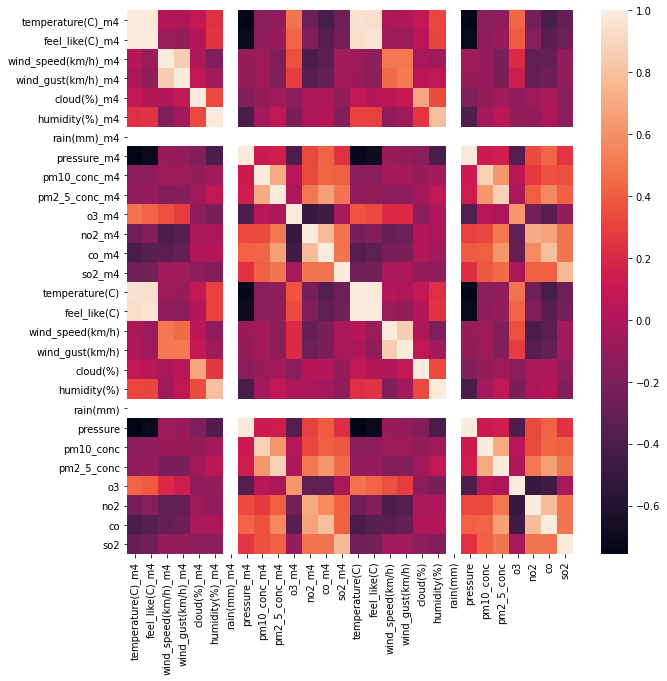

,temperature(C)_m4,feel_like(C)_m4,wind_speed(km/h)_m4,wind_gust(km/h)_m4,cloud(%)_m4,humidity(%)_m4,rain(mm)_m4,pressure_m4,pm10_conc_m4,pm2_5_conc_m4,...,cloud(%),humidity(%),rain(mm),pressure,pm10_conc,pm2_5_conc,o3,no2,co,so2
temperature(C)_m4,1.000000,0.981804,0.022072,-0.004146,0.077236,0.235015,NaN,-0.749949,-0.142688,-0.124372,...,0.079009,0.326277,NaN,-0.756727,-0.145856,-0.123624,0.425337,-0.230442,-0.410146,-0.291483
feel_like(C)_m4,0.981804,1.000000,-0.074501,-0.106970,0.019074,0.245562,NaN,-0.708076,-0.129114,-0.090984,...,0.039804,0.315933,NaN,-0.718820,-0.128716,-0.085438,0.391508,-0.160836,-0.346428,-0.257389
wind_speed(km/h)_m4,0.022072,-0.074501,1.000000,0.857861,-0.000004,-0.197643,NaN,-0.087747,-0.069626,-0.186101,...,-0.024927,-0.060780,NaN,-0.061738,-0.090234,-0.209152,0.204605,-0.323206,-0.309192,-0.104160
wind_gust(km/h)_m4,-0.004146,-0.106970,0.857861,1.000000,0.076059,-0.055238,NaN,-0.109591,-0.058304,-0.172144,...,0.043105,0.067140,NaN,-0.083545,-0.081146,-0.201822,0.132980,-0.308180,-0.276312,-0.108613
cloud(%)_m4,0.077236,0.019074,-0.000004,0.076059,1.000000,0.334178,NaN,-0.174357,-0.108911,-0.051407,...,0.684645,0.345304,NaN,-0.198411,-0.107848,-0.054839,-0.116109,-0.062367,-0.016543,-0.147655
humidity(%)_m4,0.235015,0.245562,-0.197643,-0.055238,0.334178,1.000000,NaN,-0.401875,-0.051876,0.078889,...,0.264062,0.796021,NaN,-0.391630,-0.039426,0.066020,-0.102761,-0.114140,-0.005245,-0.145881
rain(mm)_m4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure_m4,-0.749949,-0.708076,-0.087747,-0.109591,-0.174357,-0.401875,NaN,1.000000,0.117197,0.139217,...,-0.134672,-0.417390,NaN,0.985243,0.116257,0.146308,-0.376620,0.336694,0.426022,0.257323
pm10_conc_m4,-0.142688,-0.129114,-0.069626,-0.058304,-0.108911,-0.051876,NaN,0.117197,1.000000,0.707166,...,-0.095289,-0.044470,NaN,0.116353,0.876889,0.618979,0.032439,0.276931,0.365218,0.354576
pm2_5_conc_m4,-0.124372,-0.090984,-0.186101,-0.172144,-0.051407,0.078889,NaN,0.139217,0.707166,1.000000,...,-0.038625,0.077351,NaN,0.130949,0.618786,0.870160,-0.011558,0.408026,0.564595,0.413511


In [21]:
plot_corr(air_weather4)

### 3.6 Training, Testing Split

In [22]:
target = ['pm2_5_conc', 'pm10_conc']

In [23]:
def build_dataset(timeshift=1):
    drp_columns = ['datetime', 'datetime_m%i'%timeshift, 'weather_m%i'%timeshift, 'wind_direction_m%i'%timeshift, 'weather', 'wind_direction']
    dataset1 = concat_dataframe(air_weather2, timeshift)
    training1 = dataset1[dataset1['datetime'] <= "2016-12-31 23:00:00"]
    training1.drop(drp_columns, axis=1, inplace=True)
    testing1 = dataset1[(dataset1['datetime'] > "2016-12-31 23:00:00") & (dataset1['datetime'] <= "2017-12-31 23:00:00")]
    testing1.drop(drp_columns, axis=1, inplace=True)
    X1_train, y1_train = training1.drop(target, axis=1), training1['pm2_5_conc']
    X1_test, y1_test = testing1.drop(target, axis=1), testing1['pm2_5_conc']
    return X1_train, y1_train, X1_test, y1_test

***Create training dataset to predict time ahead: 1h, 4h, 8h, 12h, 16h, 24h***

In [24]:
X1_train, y1_train, X1_test, y1_test = build_dataset(1)
X4_train, y4_train, X4_test, y4_test = build_dataset(4)
X8_train, y8_train, X8_test, y8_test = build_dataset(8)
X12_train, y12_train, X12_test, y12_test = build_dataset(12)
X16_train, y16_train, X16_test, y16_test = build_dataset(16)
X20_train, y20_train, X20_test, y20_test = build_dataset(20)
X24_train, y24_train, X24_test, y24_test = build_dataset(24)

## 4. Model Construction

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

***Create simple XGBoost model for corresponding dataset***

In [26]:
def plot_pred(pred, label):
    p1_df = pd.DataFrame({'pred': pred, 'label': label, 'time': list(range(len(pred)))})
    fg, ax = plt.subplots(figsize=(10,10))
    sns.lineplot(data=p1_df, x='time', y='pred', label="pred")
    sns.lineplot(data=p1_df, x='time', y='label', label="label")
    plt.xlabel("Time")
    plt.ylabel("PM2_5 Concentration")
    plt.show()

In [27]:
model1 = xgb.XGBRegressor().fit(X1_train, y1_train)
pred1 = model1.predict(X1_test)
mean_absolute_error(pred1, y1_test)

2.1089031502536444

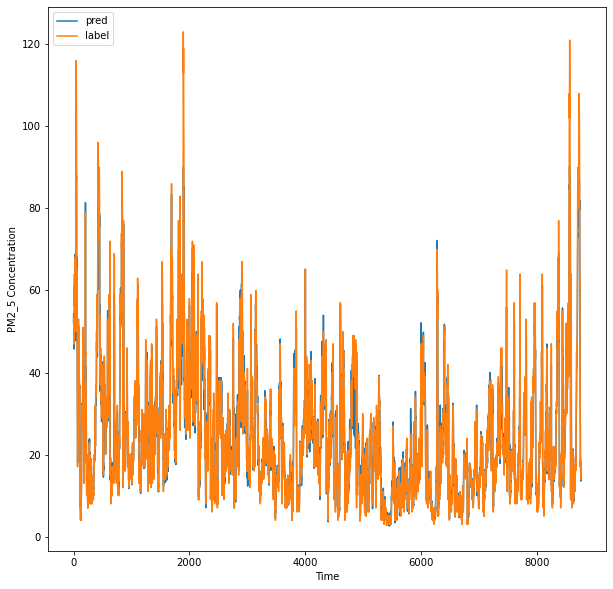

In [28]:
plot_pred(pred1, y1_test)

In [29]:
model4 = xgb.XGBRegressor().fit(X4_train, y4_train)
pred4 = model4.predict(X4_test)
mean_absolute_error(pred4, y4_test)

4.250836542139859

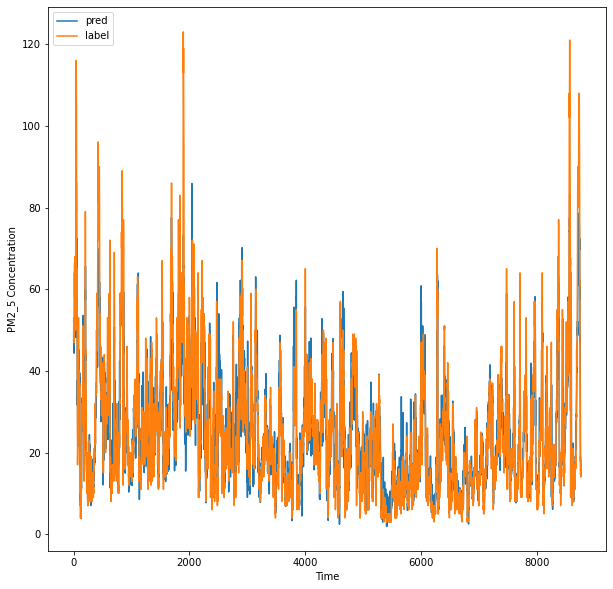

In [30]:
plot_pred(pred4, y4_test)

In [31]:
model8 = xgb.XGBRegressor().fit(X8_train, y8_train)
pred8 = model8.predict(X8_test)
mean_absolute_error(pred8, y8_test)

5.157167653076044

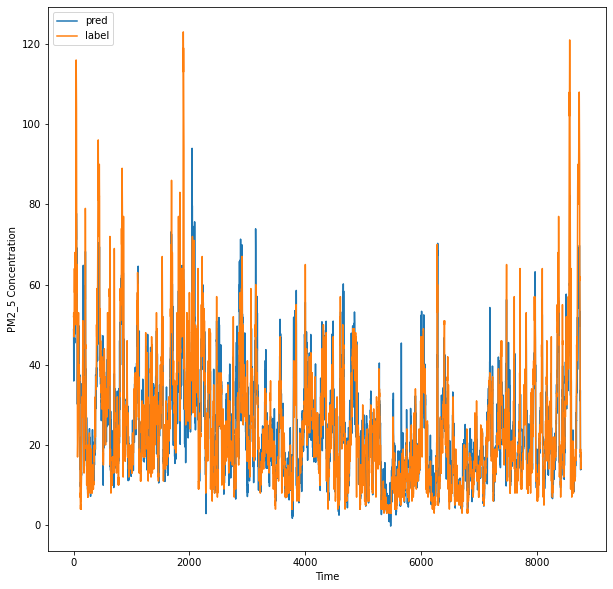

In [32]:
plot_pred(pred8, y8_test)

In [33]:
model12 = xgb.XGBRegressor().fit(X12_train, y12_train)
pred12 = model8.predict(X12_test)
mean_absolute_error(pred12, y12_test)

5.579344656110048

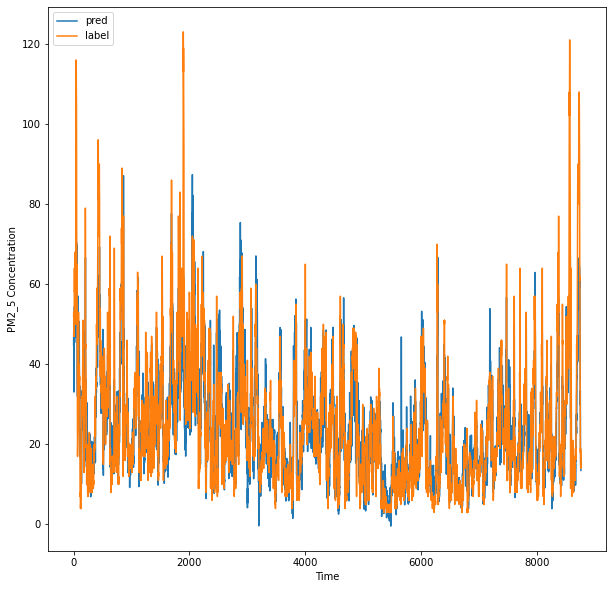

In [34]:
plot_pred(pred12, y12_test)

In [35]:
model24 = xgb.XGBRegressor().fit(X24_train, y24_train)
pred24 = model24.predict(X24_test)
mean_absolute_error(pred24, y24_test)

6.368788575998095

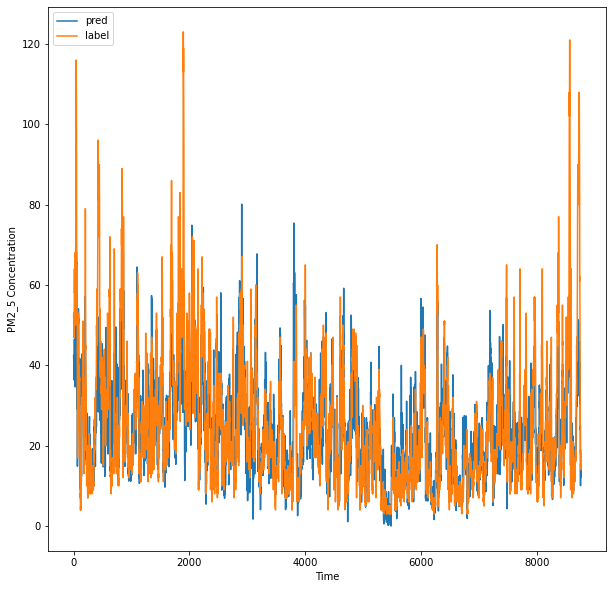

In [36]:
plot_pred(pred24, y24_test)

## 5. Explain the Results